# Tier 2: CNN + BiLSTM + Attention Training

This notebook implements training for the **Tier 2** architecture:
- Multi-scale 1D CNN for local feature extraction
- BiLSTM for sequential modeling
- **Multi-Head Self-Attention** for global context
- Residual connections and LayerNorm

## Expected Performance
- Q3 Accuracy: ~85-88%
- Q8 Accuracy: ~75-78%

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '../..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import os

# Set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
from src.config import Tier2Config, LEAKAGE_TRAIN_IDS
from src.data import ProteinDataset, create_dataloaders, collate_fn
from src.models.tier2_cnn_bilstm_attention import CNNBiLSTMAttention
from src.losses import get_multitask_loss
from src.augmentation import SequenceAugmenter
from src.metrics import evaluate_model, plot_confusion_matrix
from src.training import Trainer, create_optimizer, create_scheduler, plot_training_history

## 2. Configuration

In [3]:
config = Tier2Config(
    # Data
    max_seq_length=512,
    batch_size=32,
    
    # Model
    input_dim=40,  # 20 (one-hot) + 20 (BLOSUM62)
    use_blosum=True,
    use_positional=True,  # Add positional encoding
    
    cnn_filters=64,
    cnn_kernels=[3, 5, 7],
    lstm_hidden=256,
    lstm_layers=2,
    lstm_dropout=0.1,
    
    # Attention
    num_heads=8,
    attention_dropout=0.1,
    
    fc_hidden=256,
    fc_dropout=0.1,
    
    # Training
    learning_rate=1e-4,
    weight_decay=0.01,
    max_epochs=50,
    patience=10,
    gradient_clip=1.0,
    
    # Loss
    focal_gamma=2.0,
    q8_loss_weight=1.0,
    q3_loss_weight=0.5,
    
    # Augmentation
    augmentation_level=3,  # Moderate augmentation
    
    # Checkpointing
    checkpoint_dir='../../checkpoints/tier2_cnn_bilstm_attention',
)

print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Attention heads: {config.num_heads}")
print(f"  Augmentation level: {config.augmentation_level}")

Configuration:
  Model: tier2_cnn_bilstm_attention
  Attention heads: 8
  Augmentation level: 3


## 3. Data Loading

In [4]:
augmenter = SequenceAugmenter(level=config.augmentation_level, seed=SEED)

train_loader, val_loader = create_dataloaders(
    train_csv='../../data/train.csv',
    val_split=0.1,
    batch_size=config.batch_size,
    max_length=config.max_seq_length,
    use_blosum=config.use_blosum,
    use_positional=False,  # Model handles positional encoding
    augmentation=augmenter,
    num_workers=4,
    seed=SEED,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 205
Val batches: 23


## 4. Model Initialization

In [5]:
model = CNNBiLSTMAttention(
    input_dim=config.input_dim,
    use_positional=config.use_positional,
    cnn_filters=config.cnn_filters,
    cnn_kernels=config.cnn_kernels,
    lstm_hidden=config.lstm_hidden,
    lstm_layers=config.lstm_layers,
    lstm_dropout=config.lstm_dropout,
    num_heads=config.num_heads,
    attention_dropout=config.attention_dropout,
    fc_hidden=config.fc_hidden,
    fc_dropout=config.fc_dropout,
)

print(f"Model parameters: {model.count_parameters():,}")

Model parameters: 5,964,299


In [6]:
model = model.to(DEVICE)

# Test forward pass
sample_batch = next(iter(train_loader))
test_input = sample_batch['features'].to(DEVICE)
q8_out, q3_out = model(test_input)
print(f"Q8 output shape: {q8_out.shape}")
print(f"Q3 output shape: {q3_out.shape}")

Q8 output shape: torch.Size([32, 512, 8])
Q3 output shape: torch.Size([32, 512, 3])


## 5. Loss Function Setup

In [7]:
# Focal loss with class weights
loss_fn = get_multitask_loss(
    loss_type='focal',
    q8_weight=config.q8_loss_weight,
    q3_weight=config.q3_loss_weight,
    dynamic_weights=False,
    gamma=config.focal_gamma,
)

## 6. Training

In [8]:
optimizer = create_optimizer(
    model,
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
)

scheduler = create_scheduler(
    optimizer,
    scheduler_type='cosine',
    num_epochs=config.max_epochs,
)

In [9]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    checkpoint_dir=config.checkpoint_dir,
    gradient_clip=config.gradient_clip,
    use_amp=torch.cuda.is_available(),
    use_tracking=True,
    trackio_space_id='thethinkmachine/trackio',  # HuggingFace Space for logs
    experiment_name='tier2_cnn_bilstm_attention',
    hub_model_id='thethinkmachine/ProteinSST-CNNBiLSTM-Attention',
    training_config=config,
)

In [10]:
history = trainer.train(
    num_epochs=config.max_epochs,
    patience=config.patience,
    save_every=5,
)

📊 Logging to HuggingFace Space: thethinkmachine/trackio
* Trackio project initialized: tier2_cnn_bilstm_attention
* Trackio metrics will be synced to Hugging Face Dataset: thethinkmachine/trackio-dataset
* Found existing space: https://huggingface.co/spaces/thethinkmachine/trackio
* View dashboard by going to: https://thethinkmachine-trackio.hf.space/


* Created new run: thethinkmachine-1765720270
✓ Experiment tracking enabled (Trackio)
Starting training for 50 epochs...
Device: cuda
Model parameters: 5,964,299


Epoch 1: 100%|██████████| 205/205 [00:24<00:00,  8.42it/s, loss=1.09, q8_loss=0.909, q3_loss=0.353]


Epoch 1/50 (25.6s) | Train Loss: 1.1991 | Val Loss: 1.0327 | Q8 Acc: 0.3013 | Q3 Acc: 0.5598 | Q8 F1: 0.1856 | Q3 F1: 0.5569 | H-F1: 0.2784 | LR: 0.000099 *


Epoch 2: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=1.06, q8_loss=0.908, q3_loss=0.307] 


Epoch 2/50 (24.7s) | Train Loss: 1.1046 | Val Loss: 0.9935 | Q8 Acc: 0.3771 | Q3 Acc: 0.5936 | Q8 F1: 0.2211 | Q3 F1: 0.5839 | H-F1: 0.3207 | LR: 0.000096 *


Epoch 3: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=0.914, q8_loss=0.764, q3_loss=0.3]  


Epoch 3/50 (24.7s) | Train Loss: 1.0763 | Val Loss: 0.9609 | Q8 Acc: 0.4199 | Q3 Acc: 0.6315 | Q8 F1: 0.2642 | Q3 F1: 0.6204 | H-F1: 0.3706 | LR: 0.000092 *


Epoch 4: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=1.11, q8_loss=0.946, q3_loss=0.329] 


Epoch 4/50 (24.5s) | Train Loss: 1.0521 | Val Loss: 0.9432 | Q8 Acc: 0.3679 | Q3 Acc: 0.6082 | Q8 F1: 0.2452 | Q3 F1: 0.6054 | H-F1: 0.3491 | LR: 0.000086


Epoch 5: 100%|██████████| 205/205 [00:23<00:00,  8.88it/s, loss=1.01, q8_loss=0.855, q3_loss=0.319] 


Epoch 5/50 (24.3s) | Train Loss: 1.0340 | Val Loss: 0.9028 | Q8 Acc: 0.4239 | Q3 Acc: 0.6405 | Q8 F1: 0.2667 | Q3 F1: 0.6356 | H-F1: 0.3758 | LR: 0.000078 *


Epoch 6: 100%|██████████| 205/205 [00:22<00:00,  9.12it/s, loss=0.873, q8_loss=0.733, q3_loss=0.281]


Epoch 6/50 (23.6s) | Train Loss: 1.0187 | Val Loss: 0.9030 | Q8 Acc: 0.4629 | Q3 Acc: 0.6543 | Q8 F1: 0.2901 | Q3 F1: 0.6457 | H-F1: 0.4003 | LR: 0.000069 *


Epoch 7: 100%|██████████| 205/205 [00:22<00:00,  9.11it/s, loss=1.09, q8_loss=0.923, q3_loss=0.333] 


Epoch 7/50 (23.5s) | Train Loss: 1.0085 | Val Loss: 0.8902 | Q8 Acc: 0.4309 | Q3 Acc: 0.6422 | Q8 F1: 0.2767 | Q3 F1: 0.6402 | H-F1: 0.3864 | LR: 0.000060


Epoch 8: 100%|██████████| 205/205 [00:22<00:00,  9.04it/s, loss=0.767, q8_loss=0.641, q3_loss=0.252]


Epoch 8/50 (23.6s) | Train Loss: 1.0015 | Val Loss: 0.8804 | Q8 Acc: 0.4464 | Q3 Acc: 0.6420 | Q8 F1: 0.2784 | Q3 F1: 0.6402 | H-F1: 0.3881 | LR: 0.000051


Epoch 9: 100%|██████████| 205/205 [00:22<00:00,  9.09it/s, loss=0.86, q8_loss=0.721, q3_loss=0.277] 


Epoch 9/50 (23.5s) | Train Loss: 0.9939 | Val Loss: 0.8737 | Q8 Acc: 0.4389 | Q3 Acc: 0.6541 | Q8 F1: 0.2786 | Q3 F1: 0.6511 | H-F1: 0.3902 | LR: 0.000041


Epoch 10: 100%|██████████| 205/205 [00:23<00:00,  8.65it/s, loss=1.03, q8_loss=0.886, q3_loss=0.284] 


Epoch 10/50 (25.0s) | Train Loss: 0.9879 | Val Loss: 0.8649 | Q8 Acc: 0.4643 | Q3 Acc: 0.6603 | Q8 F1: 0.2904 | Q3 F1: 0.6554 | H-F1: 0.4025 | LR: 0.000032 *


Epoch 11: 100%|██████████| 205/205 [00:24<00:00,  8.48it/s, loss=0.887, q8_loss=0.756, q3_loss=0.262]


Epoch 11/50 (25.3s) | Train Loss: 0.9854 | Val Loss: 0.8631 | Q8 Acc: 0.4562 | Q3 Acc: 0.6608 | Q8 F1: 0.2881 | Q3 F1: 0.6571 | H-F1: 0.4006 | LR: 0.000023


Epoch 12: 100%|██████████| 205/205 [00:24<00:00,  8.54it/s, loss=0.991, q8_loss=0.856, q3_loss=0.271]


Epoch 12/50 (25.0s) | Train Loss: 0.9816 | Val Loss: 0.8793 | Q8 Acc: 0.4434 | Q3 Acc: 0.6394 | Q8 F1: 0.2794 | Q3 F1: 0.6389 | H-F1: 0.3888 | LR: 0.000015


Epoch 13: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=1.15, q8_loss=0.99, q3_loss=0.312]  


Epoch 13/50 (24.6s) | Train Loss: 0.9775 | Val Loss: 0.8616 | Q8 Acc: 0.4552 | Q3 Acc: 0.6555 | Q8 F1: 0.2892 | Q3 F1: 0.6536 | H-F1: 0.4010 | LR: 0.000009


Epoch 14: 100%|██████████| 205/205 [00:23<00:00,  8.76it/s, loss=0.944, q8_loss=0.796, q3_loss=0.295]


Epoch 14/50 (24.6s) | Train Loss: 0.9749 | Val Loss: 0.8560 | Q8 Acc: 0.4596 | Q3 Acc: 0.6612 | Q8 F1: 0.2923 | Q3 F1: 0.6582 | H-F1: 0.4049 | LR: 0.000005 *


Epoch 15: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=0.949, q8_loss=0.804, q3_loss=0.289]


Epoch 15/50 (24.8s) | Train Loss: 0.9723 | Val Loss: 0.8556 | Q8 Acc: 0.4596 | Q3 Acc: 0.6647 | Q8 F1: 0.2920 | Q3 F1: 0.6609 | H-F1: 0.4051 | LR: 0.000002 *


Epoch 16: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=1.02, q8_loss=0.869, q3_loss=0.3]   


Epoch 16/50 (24.6s) | Train Loss: 0.9705 | Val Loss: 0.8567 | Q8 Acc: 0.4582 | Q3 Acc: 0.6598 | Q8 F1: 0.2900 | Q3 F1: 0.6571 | H-F1: 0.4024 | LR: 0.000100


Epoch 17: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=1.05, q8_loss=0.915, q3_loss=0.279] 


Epoch 17/50 (24.5s) | Train Loss: 0.9866 | Val Loss: 0.8727 | Q8 Acc: 0.4552 | Q3 Acc: 0.6560 | Q8 F1: 0.2931 | Q3 F1: 0.6535 | H-F1: 0.4046 | LR: 0.000100


Epoch 18: 100%|██████████| 205/205 [00:23<00:00,  8.78it/s, loss=1.02, q8_loss=0.862, q3_loss=0.319] 


Epoch 18/50 (24.6s) | Train Loss: 0.9819 | Val Loss: 0.8560 | Q8 Acc: 0.4681 | Q3 Acc: 0.6629 | Q8 F1: 0.2958 | Q3 F1: 0.6594 | H-F1: 0.4084 | LR: 0.000099 *


Epoch 19: 100%|██████████| 205/205 [00:23<00:00,  8.75it/s, loss=0.832, q8_loss=0.709, q3_loss=0.245]


Epoch 19/50 (24.4s) | Train Loss: 0.9748 | Val Loss: 0.8807 | Q8 Acc: 0.4560 | Q3 Acc: 0.6356 | Q8 F1: 0.2903 | Q3 F1: 0.6354 | H-F1: 0.3985 | LR: 0.000098


Epoch 20: 100%|██████████| 205/205 [00:23<00:00,  8.68it/s, loss=1.06, q8_loss=0.919, q3_loss=0.29]  


Epoch 20/50 (24.6s) | Train Loss: 0.9715 | Val Loss: 0.8691 | Q8 Acc: 0.4295 | Q3 Acc: 0.6610 | Q8 F1: 0.2793 | Q3 F1: 0.6583 | H-F1: 0.3922 | LR: 0.000096


Epoch 21: 100%|██████████| 205/205 [00:23<00:00,  8.66it/s, loss=0.903, q8_loss=0.767, q3_loss=0.271]


Epoch 21/50 (24.8s) | Train Loss: 0.9642 | Val Loss: 0.8493 | Q8 Acc: 0.4638 | Q3 Acc: 0.6623 | Q8 F1: 0.2901 | Q3 F1: 0.6603 | H-F1: 0.4031 | LR: 0.000094


Epoch 22: 100%|██████████| 205/205 [00:23<00:00,  8.70it/s, loss=0.735, q8_loss=0.604, q3_loss=0.262]


Epoch 22/50 (24.6s) | Train Loss: 0.9601 | Val Loss: 0.8561 | Q8 Acc: 0.4486 | Q3 Acc: 0.6471 | Q8 F1: 0.2871 | Q3 F1: 0.6468 | H-F1: 0.3976 | LR: 0.000092


Epoch 23: 100%|██████████| 205/205 [00:23<00:00,  8.74it/s, loss=1.01, q8_loss=0.876, q3_loss=0.262] 


Epoch 23/50 (24.4s) | Train Loss: 0.9544 | Val Loss: 0.8449 | Q8 Acc: 0.4566 | Q3 Acc: 0.6686 | Q8 F1: 0.2934 | Q3 F1: 0.6628 | H-F1: 0.4067 | LR: 0.000089


Epoch 24: 100%|██████████| 205/205 [00:23<00:00,  8.65it/s, loss=0.962, q8_loss=0.818, q3_loss=0.288]


Epoch 24/50 (25.0s) | Train Loss: 0.9510 | Val Loss: 0.8347 | Q8 Acc: 0.4743 | Q3 Acc: 0.6701 | Q8 F1: 0.3023 | Q3 F1: 0.6668 | H-F1: 0.4160 | LR: 0.000086 *


Epoch 25: 100%|██████████| 205/205 [00:23<00:00,  8.69it/s, loss=0.861, q8_loss=0.746, q3_loss=0.23] 


Epoch 25/50 (24.8s) | Train Loss: 0.9435 | Val Loss: 0.8305 | Q8 Acc: 0.4800 | Q3 Acc: 0.6742 | Q8 F1: 0.3070 | Q3 F1: 0.6715 | H-F1: 0.4213 | LR: 0.000082 *


Epoch 26: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=0.976, q8_loss=0.824, q3_loss=0.304]


Epoch 26/50 (24.6s) | Train Loss: 0.9414 | Val Loss: 0.8398 | Q8 Acc: 0.4553 | Q3 Acc: 0.6593 | Q8 F1: 0.2947 | Q3 F1: 0.6582 | H-F1: 0.4071 | LR: 0.000078


Epoch 27: 100%|██████████| 205/205 [00:23<00:00,  8.62it/s, loss=0.963, q8_loss=0.826, q3_loss=0.275]


Epoch 27/50 (24.8s) | Train Loss: 0.9385 | Val Loss: 0.8293 | Q8 Acc: 0.4718 | Q3 Acc: 0.6702 | Q8 F1: 0.3037 | Q3 F1: 0.6675 | H-F1: 0.4174 | LR: 0.000074


Epoch 28: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=1.04, q8_loss=0.895, q3_loss=0.281] 


Epoch 28/50 (24.5s) | Train Loss: 0.9323 | Val Loss: 0.8271 | Q8 Acc: 0.4751 | Q3 Acc: 0.6739 | Q8 F1: 0.3060 | Q3 F1: 0.6711 | H-F1: 0.4203 | LR: 0.000069


Epoch 29: 100%|██████████| 205/205 [00:23<00:00,  8.70it/s, loss=0.782, q8_loss=0.675, q3_loss=0.213]


Epoch 29/50 (24.5s) | Train Loss: 0.9281 | Val Loss: 0.8260 | Q8 Acc: 0.4755 | Q3 Acc: 0.6802 | Q8 F1: 0.3050 | Q3 F1: 0.6760 | H-F1: 0.4203 | LR: 0.000065


Epoch 30: 100%|██████████| 205/205 [00:23<00:00,  8.75it/s, loss=0.832, q8_loss=0.718, q3_loss=0.228]


Epoch 30/50 (24.7s) | Train Loss: 0.9240 | Val Loss: 0.8259 | Q8 Acc: 0.4725 | Q3 Acc: 0.6832 | Q8 F1: 0.3074 | Q3 F1: 0.6786 | H-F1: 0.4232 | LR: 0.000060 *


Epoch 31: 100%|██████████| 205/205 [00:23<00:00,  8.70it/s, loss=1.01, q8_loss=0.862, q3_loss=0.294] 


Epoch 31/50 (24.6s) | Train Loss: 0.9197 | Val Loss: 0.8193 | Q8 Acc: 0.4611 | Q3 Acc: 0.6749 | Q8 F1: 0.3001 | Q3 F1: 0.6728 | H-F1: 0.4151 | LR: 0.000055


Epoch 32: 100%|██████████| 205/205 [00:23<00:00,  8.75it/s, loss=0.747, q8_loss=0.621, q3_loss=0.251]


Epoch 32/50 (24.6s) | Train Loss: 0.9167 | Val Loss: 0.8209 | Q8 Acc: 0.4833 | Q3 Acc: 0.6744 | Q8 F1: 0.3094 | Q3 F1: 0.6714 | H-F1: 0.4236 | LR: 0.000051 *


Epoch 33: 100%|██████████| 205/205 [00:23<00:00,  8.67it/s, loss=0.861, q8_loss=0.741, q3_loss=0.24] 


Epoch 33/50 (24.9s) | Train Loss: 0.9126 | Val Loss: 0.8169 | Q8 Acc: 0.4879 | Q3 Acc: 0.6798 | Q8 F1: 0.3132 | Q3 F1: 0.6772 | H-F1: 0.4283 | LR: 0.000046 *


Epoch 34: 100%|██████████| 205/205 [00:23<00:00,  8.73it/s, loss=0.866, q8_loss=0.733, q3_loss=0.266]


Epoch 34/50 (24.5s) | Train Loss: 0.9097 | Val Loss: 0.8172 | Q8 Acc: 0.4657 | Q3 Acc: 0.6818 | Q8 F1: 0.3074 | Q3 F1: 0.6790 | H-F1: 0.4232 | LR: 0.000041


Epoch 35: 100%|██████████| 205/205 [00:23<00:00,  8.68it/s, loss=0.744, q8_loss=0.604, q3_loss=0.279]


Epoch 35/50 (24.6s) | Train Loss: 0.9054 | Val Loss: 0.8170 | Q8 Acc: 0.4745 | Q3 Acc: 0.6901 | Q8 F1: 0.3087 | Q3 F1: 0.6843 | H-F1: 0.4255 | LR: 0.000036


Epoch 36: 100%|██████████| 205/205 [00:23<00:00,  8.62it/s, loss=0.992, q8_loss=0.858, q3_loss=0.268]


Epoch 36/50 (24.9s) | Train Loss: 0.9028 | Val Loss: 0.8130 | Q8 Acc: 0.4689 | Q3 Acc: 0.6824 | Q8 F1: 0.3090 | Q3 F1: 0.6796 | H-F1: 0.4248 | LR: 0.000032


Epoch 37: 100%|██████████| 205/205 [00:23<00:00,  8.66it/s, loss=0.956, q8_loss=0.826, q3_loss=0.26] 


Epoch 37/50 (24.7s) | Train Loss: 0.9002 | Val Loss: 0.8148 | Q8 Acc: 0.4706 | Q3 Acc: 0.6844 | Q8 F1: 0.3081 | Q3 F1: 0.6812 | H-F1: 0.4243 | LR: 0.000027


Epoch 38: 100%|██████████| 205/205 [00:23<00:00,  8.73it/s, loss=0.802, q8_loss=0.67, q3_loss=0.264] 


Epoch 38/50 (24.5s) | Train Loss: 0.8973 | Val Loss: 0.8160 | Q8 Acc: 0.4686 | Q3 Acc: 0.6849 | Q8 F1: 0.3076 | Q3 F1: 0.6818 | H-F1: 0.4240 | LR: 0.000023


Epoch 39: 100%|██████████| 205/205 [00:23<00:00,  8.70it/s, loss=0.915, q8_loss=0.774, q3_loss=0.281]


Epoch 39/50 (24.6s) | Train Loss: 0.8953 | Val Loss: 0.8109 | Q8 Acc: 0.4763 | Q3 Acc: 0.6848 | Q8 F1: 0.3109 | Q3 F1: 0.6815 | H-F1: 0.4270 | LR: 0.000019


Epoch 40: 100%|██████████| 205/205 [00:23<00:00,  8.69it/s, loss=0.768, q8_loss=0.665, q3_loss=0.207]


Epoch 40/50 (24.6s) | Train Loss: 0.8948 | Val Loss: 0.8087 | Q8 Acc: 0.4766 | Q3 Acc: 0.6864 | Q8 F1: 0.3117 | Q3 F1: 0.6831 | H-F1: 0.4281 | LR: 0.000015


Epoch 41: 100%|██████████| 205/205 [00:23<00:00,  8.69it/s, loss=0.791, q8_loss=0.671, q3_loss=0.24] 


Epoch 41/50 (24.8s) | Train Loss: 0.8949 | Val Loss: 0.8094 | Q8 Acc: 0.4808 | Q3 Acc: 0.6858 | Q8 F1: 0.3133 | Q3 F1: 0.6826 | H-F1: 0.4295 | LR: 0.000012 *


Epoch 42: 100%|██████████| 205/205 [00:23<00:00,  8.74it/s, loss=0.938, q8_loss=0.806, q3_loss=0.265]


Epoch 42/50 (24.7s) | Train Loss: 0.8913 | Val Loss: 0.8086 | Q8 Acc: 0.4773 | Q3 Acc: 0.6884 | Q8 F1: 0.3136 | Q3 F1: 0.6846 | H-F1: 0.4302 | LR: 0.000009 *


Epoch 43: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=0.868, q8_loss=0.74, q3_loss=0.255] 


Epoch 43/50 (24.5s) | Train Loss: 0.8894 | Val Loss: 0.8086 | Q8 Acc: 0.4750 | Q3 Acc: 0.6864 | Q8 F1: 0.3116 | Q3 F1: 0.6831 | H-F1: 0.4280 | LR: 0.000007


Epoch 44: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=0.957, q8_loss=0.823, q3_loss=0.268]


Epoch 44/50 (24.5s) | Train Loss: 0.8882 | Val Loss: 0.8088 | Q8 Acc: 0.4739 | Q3 Acc: 0.6867 | Q8 F1: 0.3101 | Q3 F1: 0.6834 | H-F1: 0.4266 | LR: 0.000005


Epoch 45: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=0.799, q8_loss=0.67, q3_loss=0.258] 


Epoch 45/50 (24.5s) | Train Loss: 0.8879 | Val Loss: 0.8084 | Q8 Acc: 0.4764 | Q3 Acc: 0.6869 | Q8 F1: 0.3116 | Q3 F1: 0.6836 | H-F1: 0.4281 | LR: 0.000003


Epoch 46: 100%|██████████| 205/205 [00:23<00:00,  8.70it/s, loss=0.856, q8_loss=0.727, q3_loss=0.257]


Epoch 46/50 (24.7s) | Train Loss: 0.8874 | Val Loss: 0.8084 | Q8 Acc: 0.4788 | Q3 Acc: 0.6871 | Q8 F1: 0.3124 | Q3 F1: 0.6838 | H-F1: 0.4289 | LR: 0.000002


Epoch 47: 100%|██████████| 205/205 [00:23<00:00,  8.66it/s, loss=1.08, q8_loss=0.932, q3_loss=0.298] 


Epoch 47/50 (24.6s) | Train Loss: 0.8869 | Val Loss: 0.8085 | Q8 Acc: 0.4783 | Q3 Acc: 0.6861 | Q8 F1: 0.3118 | Q3 F1: 0.6827 | H-F1: 0.4281 | LR: 0.000001


Epoch 48: 100%|██████████| 205/205 [00:23<00:00,  8.72it/s, loss=0.922, q8_loss=0.811, q3_loss=0.221]


Epoch 48/50 (24.5s) | Train Loss: 0.8869 | Val Loss: 0.8082 | Q8 Acc: 0.4771 | Q3 Acc: 0.6870 | Q8 F1: 0.3119 | Q3 F1: 0.6837 | H-F1: 0.4284 | LR: 0.000100


Epoch 49: 100%|██████████| 205/205 [00:23<00:00,  8.71it/s, loss=1.03, q8_loss=0.892, q3_loss=0.275] 


Epoch 49/50 (24.5s) | Train Loss: 0.9023 | Val Loss: 0.8231 | Q8 Acc: 0.4558 | Q3 Acc: 0.6823 | Q8 F1: 0.3047 | Q3 F1: 0.6787 | H-F1: 0.4206 | LR: 0.000100


Epoch 50: 100%|██████████| 205/205 [00:23<00:00,  8.73it/s, loss=1.06, q8_loss=0.909, q3_loss=0.296] 


Epoch 50/50 (24.5s) | Train Loss: 0.9038 | Val Loss: 0.8111 | Q8 Acc: 0.4704 | Q3 Acc: 0.6916 | Q8 F1: 0.3115 | Q3 F1: 0.6873 | H-F1: 0.4287 | LR: 0.000100
* Run finished. Uploading logs to Trackio (please wait...)
✓ Experiment tracking finished


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✓ Model pushed to: https://huggingface.co/thethinkmachine/ProteinSST-CNNBiLSTM-Attention

Training complete!
Best Harmonic F1: 0.4302
Best Q8 F1: 0.3136
Best Q8 Accuracy: 0.4773
Best Val Loss: 0.8086


## 7. Training Visualization

/tmp/ipykernel_445576/68225983.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


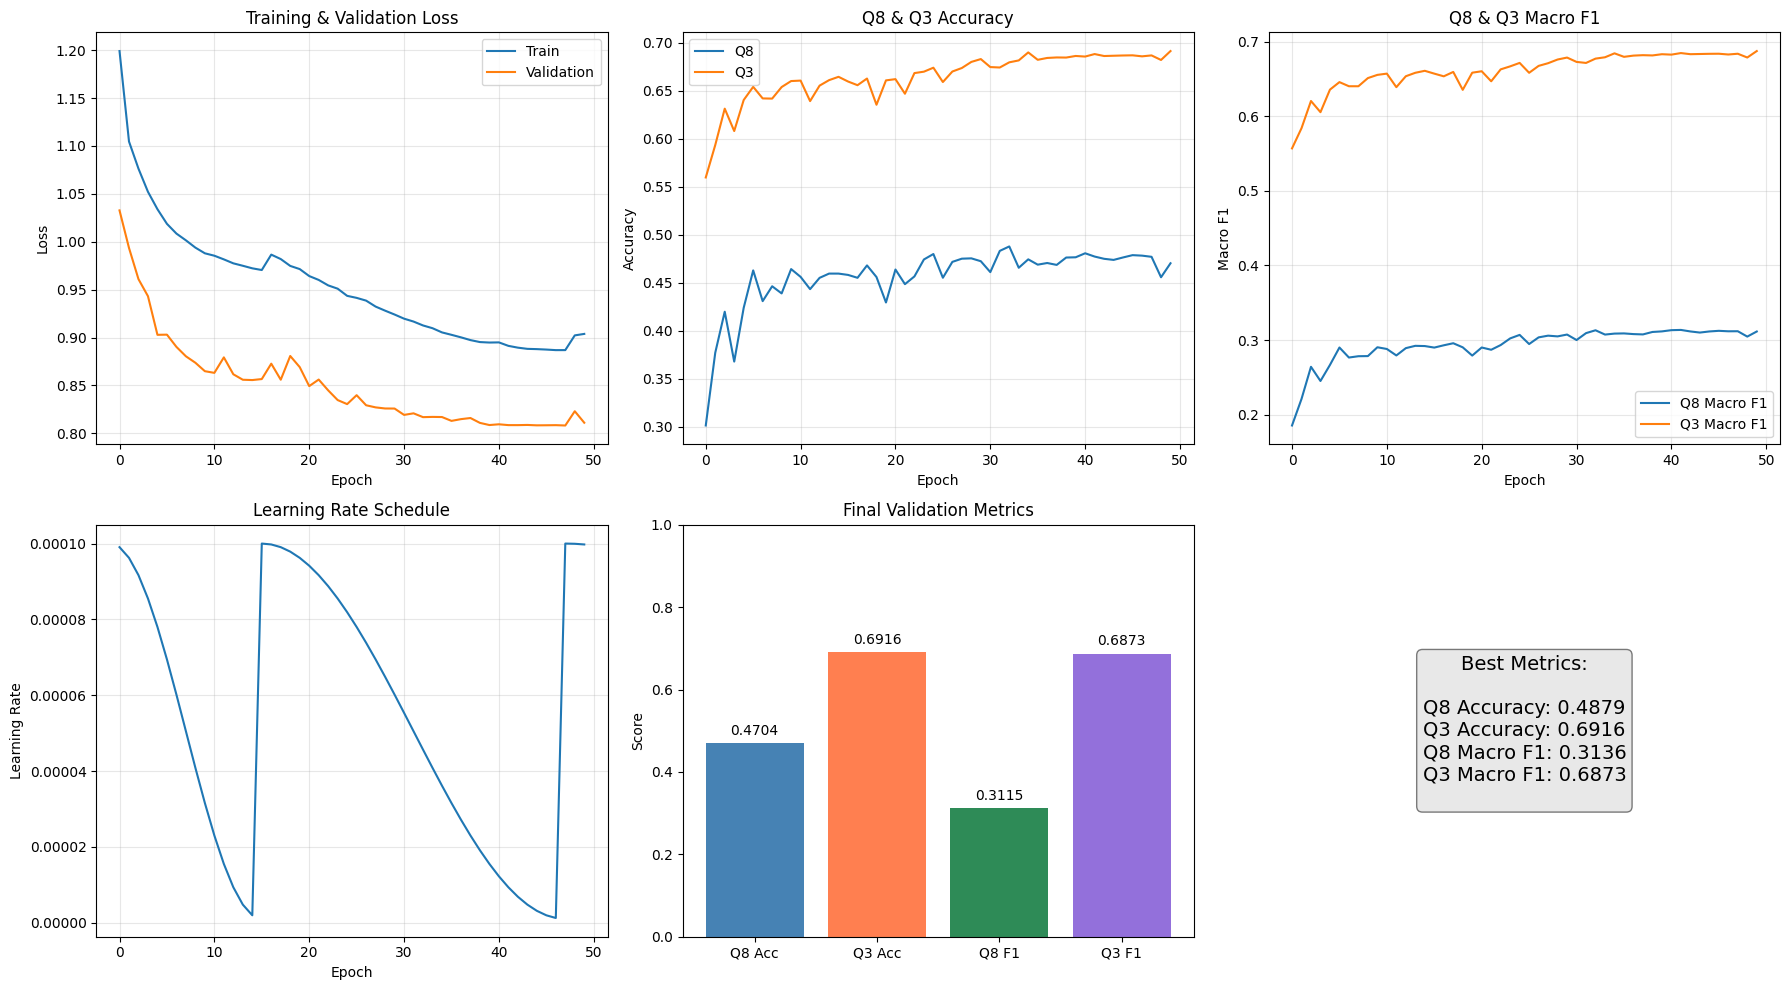

In [11]:
fig = plot_training_history(history, save_path=f'{config.checkpoint_dir}/training_history.png')
fig.show()

## 8. Evaluation

In [12]:
checkpoint = torch.load(f'{config.checkpoint_dir}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

Loaded best model from epoch 42


In [13]:
report = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=DEVICE,
    compute_sov=True,
)

report.print_report()

EVALUATION REPORT

============================== Q8 (8-state) ==============================
Accuracy: 0.4773 (47.73%)
Macro F1: 0.3136
SOV Score: 53.15

Per-class metrics:
Class           Precision    Recall       F1           Support   
------------------------------------------------------------
G (3₁₀-helix)   0.1010       0.4442       0.1645       6420
H (α-helix)     0.7827       0.6326       0.6997       52250
I (π-helix)     0.0068       0.0435       0.0118       23
E (β-strand)    0.6088       0.6536       0.6304       37526
B (β-bridge)    0.0427       0.2278       0.0719       1809
T (Turn)        0.3061       0.5095       0.3825       18325
S (Bend)        0.2641       0.1646       0.2028       13162
C (Coil)        0.8081       0.2198       0.3456       40857

============================== Q3 (3-state) ==============================
Accuracy: 0.6884 (68.84%)
Macro F1: 0.6846
SOV Score: 73.51

Per-class metrics:
Class           Precision    Recall       F1           Suppo

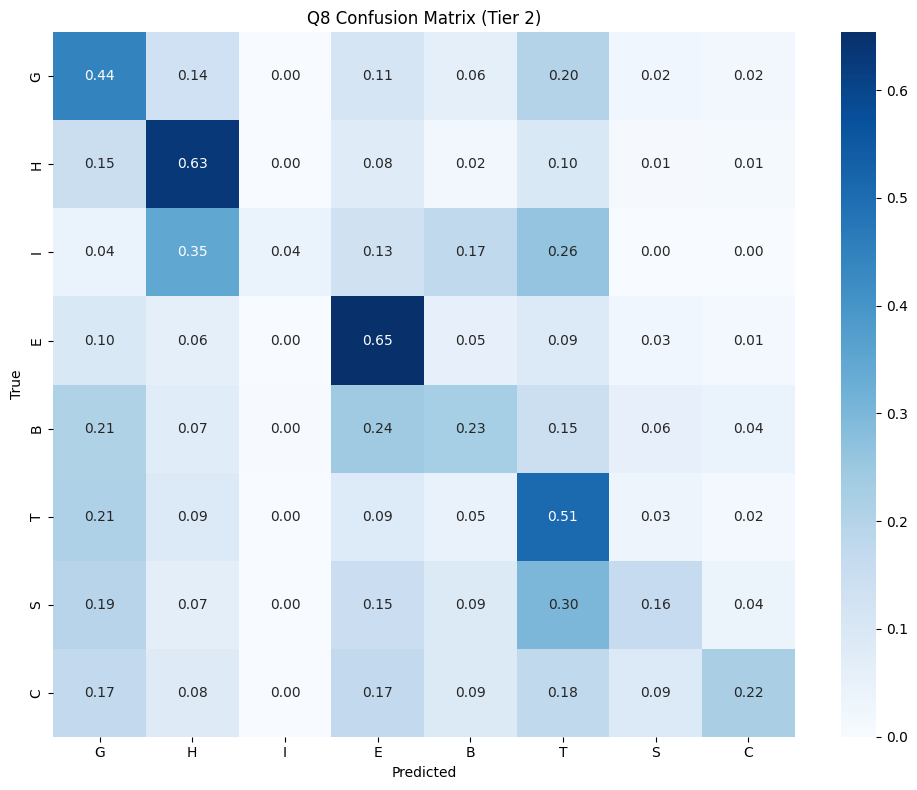

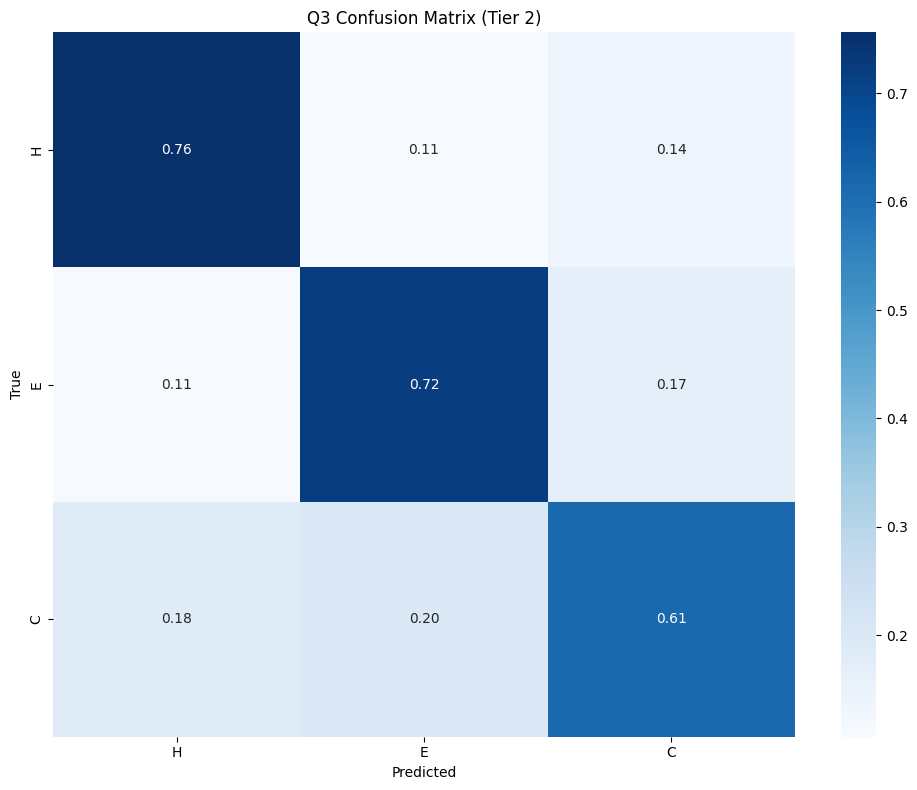

In [14]:
from src.config import SST8_CLASSES, SST3_CLASSES

fig_q8 = plot_confusion_matrix(
    report.q8_confusion_matrix,
    SST8_CLASSES,
    title='Q8 Confusion Matrix (Tier 2)',
    save_path=f'{config.checkpoint_dir}/q8_confusion_matrix.png',
)

fig_q3 = plot_confusion_matrix(
    report.q3_confusion_matrix,
    SST3_CLASSES,
    title='Q3 Confusion Matrix (Tier 2)',
    save_path=f'{config.checkpoint_dir}/q3_confusion_matrix.png',
)

## 9. Summary

In [15]:
print("=" * 60)
print("TIER 2 TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Results:")
print(f"  Q8 Accuracy: {report.q8_accuracy:.4f} ({report.q8_accuracy*100:.2f}%)")
print(f"  Q3 Accuracy: {report.q3_accuracy:.4f} ({report.q3_accuracy*100:.2f}%)")
print(f"  Q8 Macro F1: {report.q8_macro_f1:.4f}")
print(f"  Q3 Macro F1: {report.q3_macro_f1:.4f}")
if report.q8_sov:
    print(f"  Q8 SOV: {report.q8_sov:.2f}")
    print(f"  Q3 SOV: {report.q3_sov:.2f}")

print(f"\nCheckpoints saved to: {config.checkpoint_dir}")
print(f"\nComparison to Tier 1:")
print(f"  Expected improvement: +3-4% Q3, +3-5% Q8")

TIER 2 TRAINING COMPLETE

Best Results:
  Q8 Accuracy: 0.4773 (47.73%)
  Q3 Accuracy: 0.6884 (68.84%)
  Q8 Macro F1: 0.3136
  Q3 Macro F1: 0.6846
  Q8 SOV: 53.15
  Q3 SOV: 73.51

Checkpoints saved to: ../../checkpoints/tier2_cnn_bilstm_attention

Comparison to Tier 1:
  Expected improvement: +3-4% Q3, +3-5% Q8
